
# 02 — Performance Python (cours **complet**)

**Objectifs**
- Savoir **mesurer** (timeit, cProfile) et **interpréter** les hot paths
- Maîtriser les **optimisations natives** (comprehensions, generators, prealloc, bisect, itertools)
- Utiliser **NumPy/pandas** pour **vectoriser** et **différencier I/O vs CPU**
- Comprendre les **coûts cachés** (allocations, copies, conversions, Python ↔ NumPy/pandas)



## 1) Mesurer correctement

### 1.1 `timeit` — micro-benchmarks


In [1]:

import timeit
setup = "nums = list(range(10_000))"
stmt_py = "total = sum([x*x for x in nums])"
print("listcomp:", timeit.timeit(stmt_py, setup=setup, number=2000))


listcomp: 1.2001473999989685



### 1.2 `cProfile` — profil global
Astuce : profiler une fonction qui prépare et exécute un scénario.


In [2]:

import cProfile, pstats, io

def scenario():
    nums = list(range(200_000))
    return sum([x*x for x in nums])

pr = cProfile.Profile()
pr.enable()
scenario()
pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats("cumtime")
ps.print_stats(10)
print(s.getvalue())


         45 function calls in 0.026 seconds

   Ordered by: cumulative time
   List reduced from 21 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.028    0.014 c:\Users\guigu\Desktop\Quant Project\interviews\venv\lib\site-packages\IPython\core\interactiveshell.py:3543(run_code)
        2    0.000    0.000    0.028    0.014 {built-in method builtins.exec}
        1    0.005    0.005    0.025    0.025 C:\Users\guigu\AppData\Local\Temp\ipykernel_32260\1917926646.py:3(scenario)
        1    0.016    0.016    0.016    0.016 C:\Users\guigu\AppData\Local\Temp\ipykernel_32260\1917926646.py:5(<listcomp>)
        1    0.004    0.004    0.004    0.004 {built-in method builtins.sum}
        2    0.000    0.000    0.000    0.000 C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\codeop.py:117(__call__)
        2    0.000    0.000    0.000    0.000 {built-in meth


### 1.3 `line_profiler` (note)
- Installation externe : `pip install line_profiler`
- Utilisation : `@profile` sur la fonction puis `kernprof -l -v script.py`



## 2) Optimisations natives

- **List comprehension** > boucle `for` + `.append`
- **Generator** quand on **ne stocke pas** (streaming)
- **Preallocation** pour listes fixes : `arr = [0]*N`
- **`bisect`** pour recherche **O(log n)** dans liste triée
- **`itertools`** pour éviter des boucles manuelles


In [3]:

from bisect import bisect_left
data = list(range(0, 1_000_000, 3))  # trié
i = bisect_left(data, 123456)
print("pos:", i, "value:", data[i])


pos: 41152 value: 123456


In [4]:

import itertools as it
nums = [1,2,3,4,5]
pairs = list(it.combinations(nums, 2))
acc = list(it.accumulate(nums))
print("pairs:", pairs[:4], "...", "acc:", acc)


pairs: [(1, 2), (1, 3), (1, 4), (1, 5)] ... acc: [1, 3, 6, 10, 15]



## 3) Vectorisation (NumPy/pandas)

$$ \text{Éviter les boucles Python lentes ; préférer les ufuncs NumPy et opérations vectorielles.} $$


In [5]:

import numpy as np
N = 1_000_00
arr = np.arange(N, dtype=np.float64)
%timeit arr*2 + 1.5
%timeit [x*2 + 1.5 for x in arr]  # attention: arr est itérable NumPy ici


762 μs ± 60.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
15.3 ms ± 573 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)



### pandas : `apply` vs vectorisation


In [6]:

import pandas as pd
s = pd.Series(np.random.randn(200_000))
%timeit s.apply(lambda x: x*x + 1.5)
%timeit s*s + 1.5


38.7 ms ± 957 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.3 ms ± 50.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



## 4) E/S & Parsing (I/O) — conseils rapides
- Lire des gros CSV : `chunksize`, `dtype` précis, `usecols`
- Parquet/Feather (columnaire) plutôt que CSV si possible
- Éviter `.apply` ligne par ligne, préférer **vectoriser** ou **numba** (si dispo)



## 5) Graphique comparatif simple (perf relative)


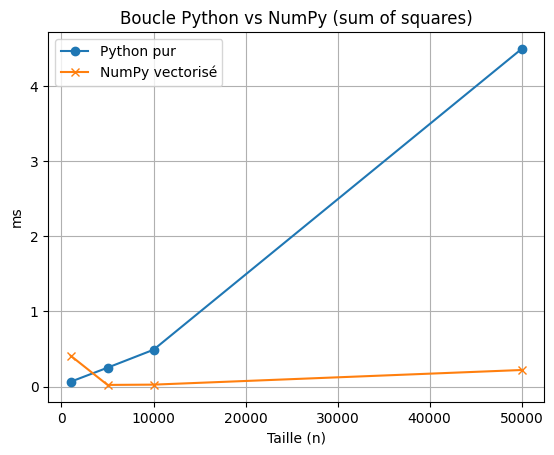

In [7]:

import numpy as np, matplotlib.pyplot as plt, time

sizes = [1000, 5000, 10_000, 50_000]
res_py, res_np = [], []

for n in sizes:
    nums = list(range(n))
    t0 = time.perf_counter()
    s = sum([x*x for x in nums])
    res_py.append((time.perf_counter()-t0)*1000)

    arr = np.arange(n)
    t0 = time.perf_counter()
    s2 = (arr*arr).sum()
    res_np.append((time.perf_counter()-t0)*1000)

plt.figure()
plt.plot(sizes, res_py, marker="o", label="Python pur")
plt.plot(sizes, res_np, marker="x", label="NumPy vectorisé")
plt.xlabel("Taille (n)"); plt.ylabel("ms"); plt.title("Boucle Python vs NumPy (sum of squares)")
plt.legend(); plt.grid(); plt.show()



---
## 📌 Fiche mémo (révision express)
- Mesure d'abord (`timeit`, `cProfile`), **optimise ensuite**
- Préfère **vectoriser** (NumPy/pandas) aux boucles Python
- `bisect` : recherche **O(log n)** dans liste triée
- **I/O** : formats columnaire + éviter `apply` au profit d'opérations vectorisées
